<a href="https://colab.research.google.com/github/hwang-sudang/kkoApplemusic/blob/simple_tags/0705Tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt


In [2]:
# 맥 용
# 나눔고딕 설치

!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)

fm._rebuild()

# 그래프에 retina display 적용

%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정

plt.rc('font', family='NanumBarunGothic') 

# 런타임 다시 시작 필수

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import os
os.chdir("/content/gdrive/My Drive/melon-playlist-continuation-master")
print(os.getcwd())
!ls

/content/gdrive/My Drive/melon-playlist-continuation-master
 0705Tags.ipynb		 PlaylistEmbedding.ipynb   split_data.py
 arena_util.py		 __pycache__		   test01.rtf
 evaluate.py		 README.md		   test.json
 genre_gn_all.json	 requirements.txt	   train.json
 genre_most_popular.py	 results.json		   uniq_tags.csv
 LICENSE		 song_meta.json		   uniq_tags.gsheet
 most_popular.py	'sparse matrix.ipynb'	   uniq_tags.xml
 NOTICE.md		 split_data.ipynb	   val.json


In [3]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

# 장르 탐구

In [4]:
genre_gn_all = pd.read_json('genre_gn_all.json', typ = 'series')
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})
genre_gn_all.head(10)

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
6,GN0200,댄스
7,GN0201,세부장르전체
8,GN0202,'80
9,GN0203,'90


In [5]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']
gnr_code.head(30)

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [6]:
## 상세 장르 코드 224개
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace=True)
dtl_gnr_code

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


In [7]:
# 상세장르 코드 추출
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])
dtl_gnr_code

,dtl_gnr_code,dtl_gnr_name,join_code
1,GN0101,세부장르전체,GN01
2,GN0102,'80,GN01
3,GN0103,'90,GN01
4,GN0104,'00,GN01
5,GN0105,'10-,GN01
...,...,...,...
247,GN2805,숙면유도,GN28
248,GN2806,반려동물,GN28
250,GN2901,세부장르전체,GN29
251,GN2902,국내뮤지컬,GN29


장르코드 트리

In [8]:
# 앞자리 네 자리 공통코드 추출 like GN01
gnr_code = gnr_code.assign(join_code=gnr_code['gnr_code'].str[0:4]) 
# join_code라는 새로운 변수를 assign을 이용해 만들었다.
gnr_code

,gnr_code,gnr_name,join_code
0,GN0100,발라드,GN01
6,GN0200,댄스,GN02
12,GN0300,랩/힙합,GN03
18,GN0400,R&B/Soul,GN04
22,GN0500,인디음악,GN05
32,GN0600,록/메탈,GN06
39,GN0700,성인가요,GN07
50,GN0800,포크/블루스,GN08
56,GN0900,POP,GN09
65,GN1000,록/메탈,GN10


In [9]:
# merge : 대분류 장르와 상세분류 장르를 함께 묶는다.
gnr_code_tree=pd.merge(gnr_code, dtl_gnr_code, how="left", on='join_code') #join_code로 묶고
gnr_code_tree[['gnr_code','gnr_name','dtl_gnr_code','dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [10]:
# 년도별 찾아보기
gnr_code_tree[gnr_code_tree['dtl_gnr_name'] == "'80"]

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
1,GN0100,발라드,GN01,GN0102,'80
6,GN0200,댄스,GN02,GN0202,'80
29,GN0600,록/메탈,GN06,GN0603,'80
66,GN1000,록/메탈,GN10,GN1011,'80
75,GN1100,일렉트로니카,GN11,GN1106,'80
84,GN1200,랩/힙합,GN12,GN1206,'80


In [11]:
gnr_code_tree[gnr_code_tree['dtl_gnr_name'] == "'10-"]  #아래 장르들이 시대별~~ 이런 곡들에 들어갈 수 있는 장르들

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
4,GN0100,발라드,GN01,GN0105,'10-
9,GN0200,댄스,GN02,GN0205,'10-
26,GN0500,인디음악,GN05,GN0509,'10-
32,GN0600,록/메탈,GN06,GN0606,'10-
47,GN0800,포크/블루스,GN08,GN0805,'10-
55,GN0900,POP,GN09,GN0908,'10-
69,GN1000,록/메탈,GN10,GN1014,'10-
78,GN1100,일렉트로니카,GN11,GN1109,'10-
87,GN1200,랩/힙합,GN12,GN1209,'10-
95,GN1300,R&B/Soul,GN13,GN1308,'10-


# 태그 탐구

In [12]:
# 데이터 불러오기.
song_meta = pd.read_json('song_meta.json', typ = 'frame')
song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4
...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,[166499],Coffin For Head Of State,[GN2000],[Fela Kuti],707984
707985,[GN0901],19860000,True Colors,44141,[11837],Change Of Heart,[GN0900],[Cyndi Lauper],707985
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,[437],스치듯 안녕,[GN0100],[윤종신],707986
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,[729868],숲의 빛,[GN1800],[Nature Piano],707987


In [13]:
train = pd.read_json('train.json', typ = 'frame')
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [14]:
# import from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
# 초기 설정 폰트 설정하기
import matplotlib.font_manager
import matplotlib.font_manager as fm

[f.name for f in fm.fontManager.ttflist if f.name.startswith("N")]

['NanumBarunGothic',
 'NanumSquareRound',
 'NanumGothic',
 'NanumSquare',
 'NanumGothic',
 'NanumSquare',
 'NanumBarunGothic',
 'NanumSquareRound',
 'NanumMyeongjo',
 'NanumMyeongjo']

In [16]:
# 필수적으로 unnest 필요
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [17]:
plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


## 태그 묶음 모음

먼저 태그묶음 모음 끼리 한번 보고

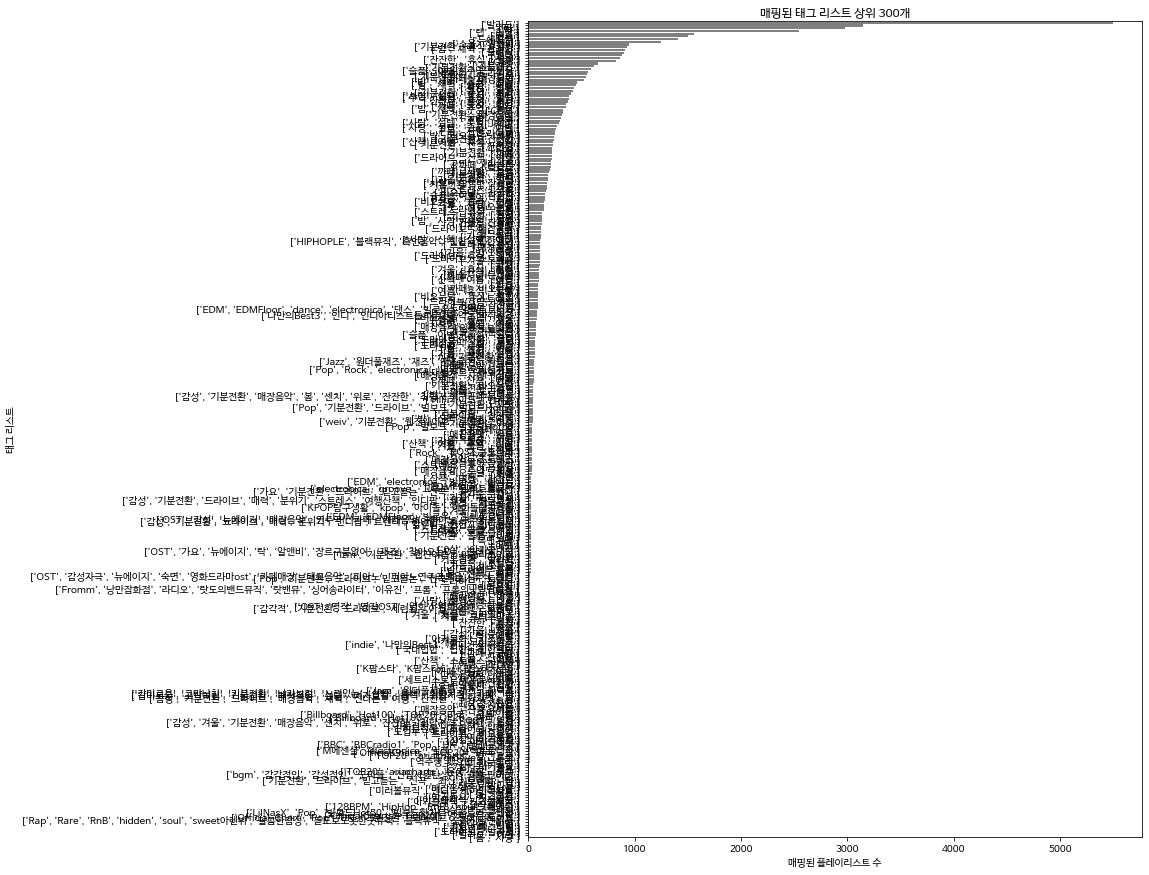

In [18]:
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 300개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(300, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
plt.rc('font', family='NanumBarunGothic')
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 300개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

저기 안에 들어간 태그들을 분석해보자 by.승기쿤

In [19]:
import re
p = re.compile("\w+")
tags_300 = []
for i in range(len(tag_list_plylst_cnt)):
    tags_300.extend(p.findall(tag_list_plylst_cnt.tag_list.iloc[i]))

set(tags_300)

{'0살',
 '128BPM',
 '3살',
 '7살',
 '8살',
 'BBC',
 'BBCradio1',
 'Billboard',
 'CCM',
 'EDM',
 'EDMFloor',
 'Fromm',
 'HIPHOPLE',
 'HiFi가이드',
 'HipHop',
 'Hot100',
 'JPOP',
 'Jazz',
 'KPOP탐구생활',
 'K팝스타',
 'K팝스타6',
 'K팝스타시즌6',
 'LilNasX',
 'M에센셜',
 'OST',
 'OfficialCharts',
 'Official_Chart',
 'Pop',
 'Rap',
 'Rare',
 'RnB',
 'Rock',
 'TOP20',
 'UK',
 'ariacharts',
 'bgm',
 'dance',
 'electronica',
 'groove',
 'hidden',
 'indie',
 'izm',
 'kpop',
 'soul',
 'sweet아렌뷔',
 'test',
 'weiv',
 '가요',
 '가을',
 '감각적',
 '감각적인',
 '감미로운',
 '감성',
 '감성자극',
 '감성적인',
 '감성힙합',
 '겨울',
 '고막남친',
 '고막여친',
 '공연',
 '국내힙합',
 '굿피플',
 '그루브',
 '금요일',
 '기분전환',
 '까페',
 '나만의Best3',
 '남자보컬',
 '낭만잡화점',
 '노래',
 '뉴에이지',
 '느낌있는',
 '다중음격',
 '달콤한감성',
 '댄스',
 '도입부',
 '드라마',
 '드라이브',
 '듣도보도못한굿뮤직',
 '라디오',
 '락',
 '랏도의밴드뮤직',
 '랏밴뮤',
 '랩',
 '런던',
 '레어한',
 '록',
 '매력',
 '매력적인',
 '매장음악',
 '메탈',
 '명작',
 '명작OST',
 '목요일',
 '미국',
 '미러볼뮤직',
 '믿고듣는',
 '발라드',
 '밤',
 '복면가왕',
 '봄',
 '분위기',
 '블랙뮤직',
 '비',
 '비오는날',
 '빌로우',
 '빌보드',
 '빌보드Hot50',
 '

In [20]:
f = open('test01.rtf', 'w')
print(tags_300, file=f) # 파일 저장하기
f.close()

### 🍊아예 댠일 태그만 200개 뽑아볼까? 횟수랑!

In [ ]:
plylst_tag_map

In [ ]:
# plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')
plylst_tag_list_sort

In [ ]:
tag_list_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'tag_cnt')
tag_list_cnt  # 단일 태그들이 얼마나 많이 태그되었나?

In [ ]:
# 4. 매핑 수 기준 상위 200개 필터링
tag_list_200 = tag_list_cnt.nlargest(200, 'tag_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
plt.rc('font', family='NanumBarunGothic')
tag_list_plylst_cnt_plot = sns.barplot(y = 'tags', x = 'tag_cnt', data = tag_list_cnt, color = 'green')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 상위 200개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

In [ ]:
tag_list_300

# 겹치는 태그 정리

In [21]:
type(tags_300)

list

In [22]:
tag300_uniq = pd.Series(tags_300).unique()
tag300_uniq

array(['발라드', '팝', '락', '랩', '힙합', '댄스', '일렉', '뉴에이지', '소울', '알앤비',
       '기분전환', '휴식', '힐링', '밤', '새벽', '잔잔한', '클래식', '인디', '재즈', 'OST',
       '스트레스', '슬픔', '이별', '추억', '회상', '드라이브', '사랑', '설렘', '까페', '매장음악',
       'CCM', 'JPOP', '봄', '비오는날', '산책', '여행', 'Pop', '여름', '가을', '공연',
       '셋리스트', '트로트', '운동', '겨울', '클럽', '월드뮤직', 'HIPHOPLE', '블랙뮤직',
       '흑인음악', '힙합엘이', '감성', '가요', '록', 'EDM', 'EDMFloor', 'dance',
       'electronica', '빌로우', '일렉트로니카', '나만의Best3', '인디아티스트들의추천음악', '피쉬슈즈',
       '연주', '월드', 'Jazz', '원더풀재즈', '재즈추천', '황덕호', 'Rock', '영국', '오피셜차트',
       '시대별차트', '해외차트', '센치', '위로', '취향저격', '카페', 'HiFi가이드', '한지훈', 'RnB',
       '빌보드', '빌보드Hot50', '신나는', 'weiv', '웹진웨이브', '위클리초이스', '드라마',
       '스쿨오브록', '금요일', 'groove', '그루브', '믿고듣는', '신곡', '최신', '트렌디', '매력',
       '분위기', '여행산책', '인디팝', '히든트랙', '팝송', 'KPOP탐구생활', 'kpop', '아이돌',
       '아이돌탐구생활', '연주곡', '카페음악', '피아노', '편안한', '7살', '키즈클래식', '노래',
       '복면가왕', '비', '0살', '아기클래식', '장르구분없이', '찾아오는DJ', 'izm', '웹진이즘',
       '

- 발라드 : 발라드, 
- 팝 : Pop, 팝, 팝송, 가요
- 재즈 : 재즈, Jazz, 재즈추천, 황덕호, 원더풀재즈, 
- 힙합 : Hiphop, HipHop, Rap, 힙합엘이, HIPHOPLE, 국내힙합, 랩, 힙합,
- 락 : Rock, 락, 록, 
- 굿피플 : 예능판미생, 신입사원탄생기, 굿피플
- 알앤비 : 알앤비, 숨겨진알앤비송, RnB, sweet아렌뷔, soul, 소울
- 흑인음악 : 흑인음악, 블랙뮤직
- 그루브 : 그루브, groove, 
- 클래식 : 클래식
- 인디 : 인디, 인디팝, 케이인디차트, 인디음악, indie, 인디아티스트들의추천음악, 미러볼뮤직, 
- 컨트리 : 컨트리
- 캐롤 : 크리스마스, 캐롤 
- CCM : CCM
- JPOP : JPOP
- EDM : EDM, EDMFloor, 클럽
- 댄스 : 댄스, dance
- 일렉 : electronica, 일렉트로니카, 일렉,
- 키즈동요 : 키즈동요, 3살, 7살
- kpop : KPOP탐구생활, kpop, 아이돌, 아이돌탐구생활
- 프롬 : Fromm, 프롬, 프롬의낭만잡화점, 낭만잡화점, 
- OST : OST, 명작OST, 영화OST, 명작, 영화, 영화드라마ost, 드라마, 
- 이즘 :izm, 웹진이즘
- weiv : weiv, 웹진웨이브, 웨이브 
- K팝스타 : K팝스타, K팝스타6, K팝스타시즌6, 
- 랏도의밴드뮤직 : 랏도의밴드뮤직, 랏밴뮤, 
- 영국 : 영국, OfficalCharts, 오피셜차트, UK, Official_Chart, LilNasX
- 빌보드 : 빌보드, 빌보드Hot50, 빌보드핫차트, Billboard, 미국, Hot100,
- 휴식 : 휴식, 힐링, 휴식_힐링, 
- 까페 : 카페, 매장음악, 까페, 카페매장, 런던, 카페음악, 
- BBC : BBC, BBCradio1,
- 피아노 : 피아노, 피아노연주곡모음
- 감성 : 감성, 감성힙합, 감성자극, 감성적인
- 감각 : 감각, 감각적, 감각적인, 느낌있는 
- 슬픔 : '이별', '추억', '회상', '슬픔'
- 레어한 : 레어한, Rare, hidden
- 여행 : 여행, 여행산책, 영화드라마ost
- 휴식 : 힐링, 휴식 
- 월드뮤직 : 월드뮤직, 월드
- 신곡 : '신곡', '최신', '트렌디', '트렌드'
- 어린이 : 아기동화, 키즈동화, 키즈클래식, 태교음악, 0살, 3살, 7살, 8살, 아기동요, 키즈동요, 정서발달, 
- 연주 : 연주, 연주곡, 
- 셋리스트 : 셋리스트, 세트리스트
- 비 : 비, 비오는날
- 운동 : 128BPM, 운동


# 역으로 2개 이상의 관련 태그를 달아야 하는 아이들
- 숨겨진알앤비송 : Rare, hidden, R&B
- 키즈클래식 : 태교음악, 클래식
- 아무로나미에 : 세트리스트




문득 태그 분류를 하다가, 사람이 손으로 하는 게 과연 정확할 지 모르겠다는 생각을 함.. 그러나 우선 이렇게 가보고 태그간 유사도를 찾을 방법을 구하자.



## 노가다로 대표 태그끼리 묶은 3차원 리스트만듦
#### 왜? : 차원이 달라서... 매트릭스나 데이터 베이스는 무리라고 생각해서 일단은 3차원으로 각각 크기가 다른 리스트로 만들었다.
#### 결국 공포의 포문인가요?

In [29]:
# 위의 대표태그대로 딕셔너리를 만들자
# csv, txt 파일로 변환할 수 없어서 노가다함
ballad = ["발라드"]
pop = ['팝','Pop', '팝송', '가요']
jazz = ['재즈', 'Jazz', '재즈추천', '황덕호', '원더풀재즈']
hiphop = ["힙합",'Hiphop', 'HipHop', 'Rap', '힙합엘이', 'HIPHOPLE', '국내힙합', '랩']
rock = ["락", "Rock", "록"]
gppl = ["굿피플", "예능판미생", "신입사원탄생기"]
rnb = ['알앤비', '숨겨진알앤비송', 'RnB', 'sweet아렌뷔', 'soul', '소울']
blkmusic=['흑인음악', '블랙뮤직']
groove=['그루브',"groove"]
classic = ["클래식", 'classic']
indie=['인디',"indie", '인디팝', '케이인디차트', '인디음악', '인디아티스트들의추천음악', '미러볼뮤직']
country = ['컨트리']
carol = ['캐롤', '크리스마스']
EDM = ['EDM', 'EDMFloor', '클럽']
dance = ['댄스', 'dance']
elec = ["electronica", "일렉트로니카", "일렉"]
kids = ["키즈동요", "3살", "7살"]
kpop = ["kpop", "KPOP탐구생활", "아이돌", "아이돌탐구생활"]
fromm = ['Fromm', '프롬', '프롬의낭만잡화점', '낭만잡화점']
ost = ["OST", "명작OST", "영화OST", "명작", "영화", "영화드라마ost", "드라마"]
izm = ["izm","웹진이즘"]
weiv = ['weiv', '웹진웨이브', '웨이브']
kpstar = ['K팝스타', 'K팝스타6', 'K팝스타시즌6']
ratdo = ['랏도의밴드뮤직', '랏밴뮤']
uk=['영국', 'OfficalCharts', '오피셜차트', 'UK', 'Official_Chart', 'LilNasX']
billboards=['빌보드', '빌보드Hot50', '빌보드핫차트', 'Billboard', '미국', 'Hot100']
rest = ['휴식', '힐링', '휴식_힐링']
cafe = ['카페', '매장음악', '까페', '카페매장', '런던', '카페음악']
bbc = ['BBC', 'BBCradio1']
piano = ['피아노', '피아노연주곡모임']
mood=['감성', '감성힙합', '감성자극', '감성적인', '달콤한감성']
feel=['감각', '감각적', '감각적인', '느낌있는']
sad=['이별', '추억', '회상', '슬픔']
rare=['레어한', 'Rare', 'hidden']
travel=['여행', '여행산책','영화드라마ost']
healing=['힐링', '휴식']
world=['월드뮤직', '월드']
new_=['신곡', '최신', '트렌디', '트렌드']
kids=['아기동화', '키즈동화', '키즈클래식', '태교음악', '0살', '3살', '7살', '8살', '아기동요', '키즈동요', '정서발달'
'연주', '연주곡']
setlist= ['셋리스트', '세트리스트']
rain=['비', '비오는날']
exercise=['128BPM', '운동']


main_tags=[ballad,pop,jazz,hiphop, rock, gppl, rnb, blkmusic, groove, classic,
           indie, country, carol, EDM, dance, elec, kids, fromm,  ost, izm, weiv, kpstar,
           carol, EDM, dance, elec, kids, fromm,  ost, izm, weiv, kpstar,
           ratdo, uk, billboards, rest, cafe, bbc, piano, mood, feel, sad, rare, travel, healing, 
           world, new_, kids, setlist, rain, exercise]

main_tags2 = ['뉴에이지','기분전환', '휴식', '힐링', '밤', '새벽', '잔잔한','스트레스', '드라이브', '사랑', '설렘',
              '봄', '산책', '여행', '여름', '가을', '공연','트로트', '운동', '겨울', '빌로우', '나만의Best3',
              '피쉬슈즈', '시대별차트', '해외차트', '센치', '위로', '취향저격', 'HiFi가이드', '한지훈','신나는', '위클리초이스',
              '스쿨오브록', '금요일', '믿고듣는',  '매력','분위기', '히든트랙', '연주곡', '편안한',  '노래','복면가왕', '장르구분없이', '찾아오는DJ', 
              '숙면', '목요일', '라디오', '싱어송라이터','이유진','한동윤','세련된', '아침',  'test', '메탈', '다중음격',
              '아무로나미에', '감미로운', '고막남친', '남자보컬', '음색', '고막여친', '매력적인','여자보컬',  'TOP20', '도입부',
              'M에센셜', 'ariacharts', '호주', '역주행_했으면_하는노래', 'bgm', '듣도보도못한굿뮤직', '페스티벌', 'CCM', 'JPOP']


In [30]:
main_tags

[['발라드'],
 ['팝', 'Pop', '팝송', '가요'],
 ['재즈', 'Jazz', '재즈추천', '황덕호', '원더풀재즈'],
 ['힙합', 'Hiphop', 'HipHop', 'Rap', '힙합엘이', 'HIPHOPLE', '국내힙합', '랩'],
 ['락', 'Rock', '록'],
 ['굿피플', '예능판미생', '신입사원탄생기'],
 ['알앤비', '숨겨진알앤비송', 'RnB', 'sweet아렌뷔', 'soul', '소울'],
 ['흑인음악', '블랙뮤직'],
 ['그루브', 'groove'],
 ['클래식', 'classic'],
 ['인디', 'indie', '인디팝', '케이인디차트', '인디음악', '인디아티스트들의추천음악', '미러볼뮤직'],
 ['컨트리'],
 ['캐롤', '크리스마스'],
 ['EDM', 'EDMFloor', '클럽'],
 ['댄스', 'dance'],
 ['electronica', '일렉트로니카', '일렉'],
 ['아기동화',
  '키즈동화',
  '키즈클래식',
  '태교음악',
  '0살',
  '3살',
  '7살',
  '8살',
  '아기동요',
  '키즈동요',
  '정서발달연주',
  '연주곡'],
 ['Fromm', '프롬', '프롬의낭만잡화점', '낭만잡화점'],
 ['OST', '명작OST', '영화OST', '명작', '영화', '영화드라마ost', '드라마'],
 ['izm', '웹진이즘'],
 ['weiv', '웹진웨이브', '웨이브'],
 ['K팝스타', 'K팝스타6', 'K팝스타시즌6'],
 ['캐롤', '크리스마스'],
 ['EDM', 'EDMFloor', '클럽'],
 ['댄스', 'dance'],
 ['electronica', '일렉트로니카', '일렉'],
 ['아기동화',
  '키즈동화',
  '키즈클래식',
  '태교음악',
  '0살',
  '3살',
  '7살',
  '8살',
  '아기동요',
  '키즈동요',
  '정서발달연주',
  '연주곡'],
 ['Fromm',

# 본격적으로 플레이리스트의 태그를 간단화 시킨다.

In [25]:
print(train.columns) #'tags', 'id', 'plylst_title', 'songs', 'like_cnt', 'updt_date'
train

Index(['tags', 'id', 'plylst_title', 'songs', 'like_cnt', 'updt_date'], dtype='object')


,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [26]:
# 'tags', 'id', 'plylst_title', 'songs', 'like_cnt', 'updt_date'
train_new=train[['tags','id','songs']]
type(train_new['tags'][1]) # 리스트 값....


# 우선 태그들을 모두 풀어헤쳐서... 

list

In [33]:
tags_x=train_new['tags'].values # main tags

'Pop'

# 오류: 태그 간단화 시키기 - 정말 2중 포문뿐인가?